# Part 4: Feature Selection

## Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier 
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis , QuadraticDiscriminantAnalysis
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.tree import ExtraTreeClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.metrics import f1_score,accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score, confusion_matrix
import matplotlib.pyplot as plt
from imblearn.ensemble import EasyEnsembleClassifier


Bad key "text.kerning_factor" on line 4 in
C:\Users\sumai\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Load Dataset

Please see the link to know more about the dataset: https://archive.ics.uci.edu/ml/datasets/Parkinson%27s+Disease+Classification#

In [2]:
df = pd.read_csv('preprocessed_speech_features.csv')
df = df. drop('Unnamed: 0', axis=1)
df.columns = df.columns.str.lower()

In [3]:
features = df.columns.to_list()

## Split Input and Traget Variables

In [4]:
X = df.drop('class', axis = 1) 
y = df['class']

In [5]:
X.columns

Index(['gender', 'ppe', 'dfa', 'rpde', 'numpulses', 'numperiodspulses',
       'meanperiodpulses', 'stddevperiodpulses', 'locpctjitter',
       'locabsjitter',
       ...
       'tqwt_kurtosisvalue_dec_27', 'tqwt_kurtosisvalue_dec_28',
       'tqwt_kurtosisvalue_dec_29', 'tqwt_kurtosisvalue_dec_30',
       'tqwt_kurtosisvalue_dec_31', 'tqwt_kurtosisvalue_dec_32',
       'tqwt_kurtosisvalue_dec_33', 'tqwt_kurtosisvalue_dec_34',
       'tqwt_kurtosisvalue_dec_35', 'tqwt_kurtosisvalue_dec_36'],
      dtype='object', length=753)

## Train Test Split

In [6]:
# train_test_split is used to split the dataset into test set and train set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state =0)

print("Original shape of dataset: {}".format(df.shape))         # shape of original dataset
print("Shape of training dataset: {}".format(X_train.shape))      # shape of training dataset after split
print("Shape of testing dataset: {}".format(X_test.shape))        # shape of testing dataset after split

Original shape of dataset: (756, 754)
Shape of training dataset: (604, 753)
Shape of testing dataset: (152, 753)


## Oversampling the minor class

In [7]:
def ovsample(X_train, y_train):
    
    # 'resample' is located under sklearn.utils
    from sklearn.utils import resample
    
    # concatenate training data back together
    train_data = pd.concat([X_train, y_train], axis = 1)

    # separate minority and majority class
    not_par = train_data[train_data['class']==0]
    Parkinsons = train_data[train_data['class']==1]

    # we are oversampling the minority class to match the number of majority classs
    Parkinsons_oversampled = resample(not_par,
                           replace = True, # Sample with replacement
                           n_samples = len(Parkinsons), # Match number in majority class
                           random_state=27)

    # combine majority and upsampled minority
    oversampled = pd.concat([Parkinsons, Parkinsons_oversampled])

    X_train_ov = oversampled.drop('class', axis = 1) 
    y_train_ov = oversampled['class']
    
    return X_train_ov, y_train_ov

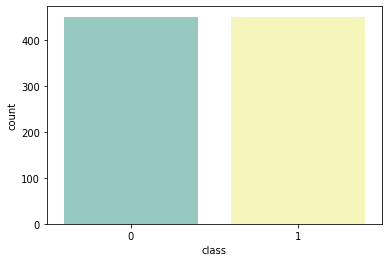

In [8]:
X_train, y_train = ovsample(X_train, y_train)
sns.countplot(y_train, palette='Set3')

## Defining all the functions

#### Writing a function that returns the evaluation metrics as a DataFrame

In [9]:
def model_comparison(models =[], model_names= []):
    
    acc = []
    prec = []
    recal = []
    f1_train = []
    f1_test = []
    roc_auc = []
    pr_auc = []
    
    for model in range(len(models)):
        clf = models[model]
        clf.fit(X_train, y_train)
        y_hat = clf.predict(X_test)
        y_hat_train = clf.predict(X_train) 
        pred_prob = clf.predict_proba(X_test)
        precision, recall, _ = precision_recall_curve(y_test, pred_prob[:, 1], pos_label=1)

        
        f1_train.append(f1_score(y_hat_train, y_train))
        f1_test.append(f1_score(y_hat, y_test))
        acc.append(accuracy_score(y_hat, y_test))
        prec.append(precision_score(y_hat, y_test))
        recal.append(recall_score(y_hat, y_test))
        roc_auc.append(roc_auc_score(y_test, y_hat))
        pr_auc.append(auc(recall, precision))
        
    compare = pd.DataFrame({'Algorithm' : model_names , 'ROC_AUC': roc_auc, 'PR_AUC': pr_auc, 'Precision': prec, 'Recall': recal, 'F1_Train': f1_train, 'F1_Test': f1_test, 'Accuracy' : acc, })
    return compare

#### Writing a function returns Macro and Weighted average of Recall Score

In [10]:
def macro_weighted(y_test, y_hat):
    
    rec = metrics.recall_score(y_test, y_hat)
    print ("Recall Score:", round(rec, 4))
    
    print ('.')

    rec_mac = metrics.recall_score(y_test, y_hat, average = 'macro')
    print ("Macro Average of Recall Score:", round(rec_mac, 4))

    rec_wei = metrics.recall_score(y_test, y_hat, average = 'weighted')
    print ("Weighted Average of Recall Score:", round(rec_wei, 4))

#### Writing a function returns Macro and Weighted average of Recall Score, Precision, and F1 Score

In [11]:
def macro_weighted_prec_rec(y_test, y_hat):
    
    rec = metrics.recall_score(y_test, y_hat)
    print ("Recall Score:", round(rec, 4))
    
    rec_mac = metrics.recall_score(y_test, y_hat, average = 'macro')
    print ("Macro Average of Recall Score:", rec_mac)

    rec_wei = metrics.recall_score(y_test, y_hat, average = 'weighted')
    print ("Weighted Average of Recall Score:", rec_wei)
    
    prec_mac = metrics.precision_score(y_test, y_hat, average = 'macro')
    print ("Macro Average of Precision Score:", prec_mac)

    prec_wei = metrics.precision_score(y_test, y_hat, average = 'weighted')
    print ("Weighted Average of Precision Score:", prec_wei)

    f1_mac = metrics.f1_score(y_test, y_hat, average = 'macro')
    print ("Macro Average of F1 Score:", f1_mac)

    f1_wei = metrics.f1_score(y_test, y_hat, average = 'weighted')
    print ("Weighted Average of F1 Score:", f1_wei)
    
    print ('.')
    
    acc = metrics.accuracy_score(y_test, y_hat)
    print ("Accuracy Score:", acc) 

#### ROC_AUC, Precision Recall AUC and the Confusion Matrices

In [12]:
def roc_pr_cm(models=[]):
    
    roc_auc = []
    pr_auc = []

    for model in range(len(models)):
        clf = models[model]
        clf.fit(X_train, y_train)
        y_hat = clf.predict(X_test)
        y_hat_train = clf.predict(X_train) 
    
        # predict probabilities
        pred_prob = clf.predict_proba(X_test)
    
        # Print the confusion matrix
        print('---------------------------------------------------------------')
        
        data = confusion_matrix(y_test, y_hat)
        df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
        df_cm.index.name = 'Actual'
        df_cm.columns.name = 'Predicted'
        plt.figure(figsize = (6, 4))
        #sns.set(font_scale=1.4) #for label size
        sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 12})# font size
        plt.show()
        
        tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
        print ("TP: {}, FP: {}, TN: {}, FN: {}".format(tp, fp, tn, fn))

        # Print the precision and recall, among other metrics
        print('---------------------------------------------------------------')
        print(metrics.classification_report(y_test, y_hat, digits=3))
        
        print('---------------------------------------------------------------')
        
        macro_weighted(y_test, y_hat)
        
        print('---------------------------------------------------------------')
     
        fpr, tpr, thresh = roc_curve(y_test, pred_prob[:, 1], pos_label=1)
        roc_auc.append(roc_auc_score(y_test, y_hat))
    
        plt.style.use('seaborn')
        plt.figure(figsize=(8, 4))
        # plot roc curves
        plt.plot(fpr, tpr, label = models[model])
    
        plt.title('ROC curve where AUC= {}'.format(roc_auc[model]))
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive rate')

        plt.legend(loc='best')
        plt.savefig('ROC', dpi=300)
        plt.show();
    
        # calculate model precision-recall curve
        # precision, recall, _ = precision_recall_curve(y_hat , y_test)
        precision, recall, _ = precision_recall_curve(y_test, pred_prob[:, 1], pos_label=1)
        pr_auc.append(auc(recall, precision))
    
        # plot the model precision-recall curve
        plt.style.use('seaborn')
        plt.figure(figsize=(8, 4))
        plt.plot(recall, precision, marker='.', label = models[model])
        plt.title('Precision Recall curve AUC= {}'.format(pr_auc[model]))
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc='best')
        plt.show()

## (a) Feature selection using SelectFromModel and LassoCV

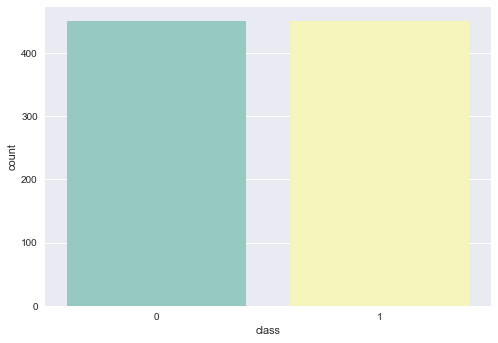

In [65]:
df = pd.read_csv('preprocessed_speech_features.csv')
df = df. drop('Unnamed: 0', axis=1)
df.columns = df.columns.str.lower()

X = df.drop('class', axis = 1) 
y = df['class']

# train_test_split is used to split the dataset into test set and train set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 0)

X_train, y_train = ovsample(X_train, y_train)
sns.countplot(y_train, palette='Set3')

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

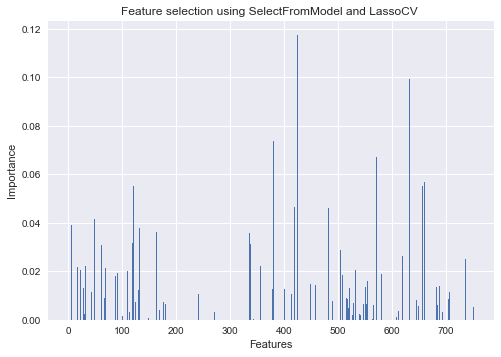

Selected features: ['tqwt_entropy_log_dec_33' 'tqwt_minvalue_dec_25'
 'tqwt_entropy_shannon_dec_25' 'tqwt_meanvalue_dec_36'
 'tqwt_kurtosisvalue_dec_33' 'tqwt_kurtosisvalue_dec_31'
 'tqwt_maxvalue_dec_17' 'std_9th_delta' 'tqwt_maxvalue_dec_13'
 'tqwt_entropy_log_dec_28' 'tqwt_tkeo_std_dec_19' 'tqwt_meanvalue_dec_22'
 'imf_snr_seo' 'tqwt_meanvalue_dec_5' 'tqwt_kurtosisvalue_dec_27']


In [66]:
from sklearn.linear_model import LassoCV
import warnings
warnings.filterwarnings('ignore')

clf = LassoCV(random_state=42).fit(X_train, y_train)
importance = np.abs(clf.coef_)

idx_features = (-importance).argsort()[:15]
name_features = np.array(X.columns.to_list())[idx_features]

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title("Feature selection using SelectFromModel and LassoCV ")
plt.show()

print('Selected features: {}'.format(name_features))

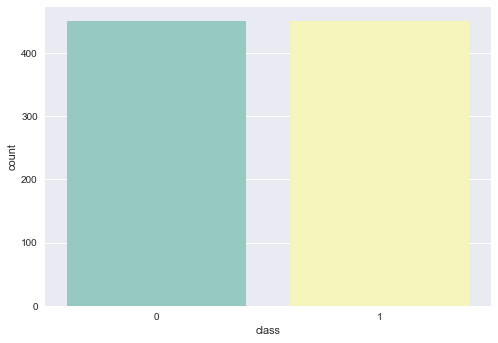

In [67]:
df = pd.read_csv('preprocessed_speech_features.csv', usecols = ['tqwt_entropy_log_dec_33', 'tqwt_minvalue_dec_25',
 'tqwt_entropy_shannon_dec_25', 'tqwt_meanvalue_dec_36',
 'tqwt_kurtosisvalue_dec_33', 'tqwt_kurtosisvalue_dec_31',
 'tqwt_maxvalue_dec_17', 'std_9th_delta', 'tqwt_maxvalue_dec_13',
 'tqwt_entropy_log_dec_28', 'tqwt_tkeo_std_dec_19', 'tqwt_meanvalue_dec_22',
 'imf_snr_seo', 'tqwt_meanvalue_dec_5', 'tqwt_kurtosisvalue_dec_27', 'class'])

X = df.drop('class', axis = 1) 
y = df['class']

# train_test_split is used to split the dataset into test set and train set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 0)

X_train, y_train = ovsample(X_train, y_train)
sns.countplot(y_train, palette='Set3')

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [68]:
models = [LGBMClassifier(random_state = 42)]
model_names=['LGBMClassifier']
model_comparison(models, model_names)

,Algorithm,ROC_AUC,PR_AUC,Precision,Recall,F1_Train,F1_Test,Accuracy
0,LGBMClassifier,0.79386,0.946082,0.95614,0.886179,1.0,0.919831,0.875


---------------------------------------------------------------


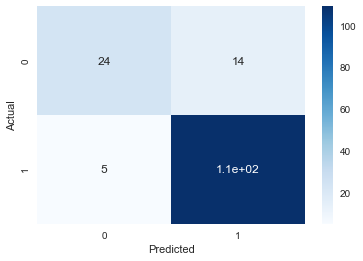

TP: 109, FP: 14, TN: 24, FN: 5
---------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.828     0.632     0.716        38
           1      0.886     0.956     0.920       114

    accuracy                          0.875       152
   macro avg      0.857     0.794     0.818       152
weighted avg      0.872     0.875     0.869       152

---------------------------------------------------------------
Recall Score: 0.9561
.
Macro Average of Recall Score: 0.7939
Weighted Average of Recall Score: 0.875
---------------------------------------------------------------


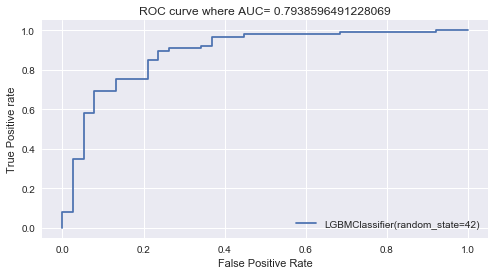

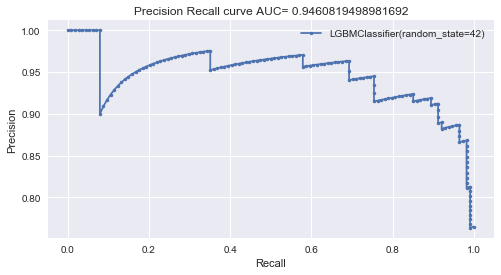

In [69]:
models = [LGBMClassifier(random_state = 42)]
roc_pr_cm(models)

## (b) Feature Selection: RandomForest Recursive Feature Elimination

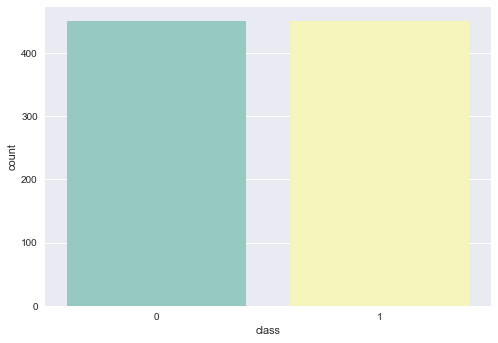

In [25]:
df = pd.read_csv('preprocessed_speech_features.csv')
df = df. drop('Unnamed: 0', axis=1)
df.columns = df.columns.str.lower()

X = df.drop('class', axis = 1) 
y = df['class']

# train_test_split is used to split the dataset into test set and train set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 0)

X_train, y_train = ovsample(X_train, y_train)
sns.countplot(y_train, palette='Set3')

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### sklearn.feature_selection.RFE

In [26]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42, n_estimators=100, criterion='entropy', max_depth=20, max_features='auto')

from sklearn.feature_selection import RFE
rfe = RFE(estimator=rf, n_features_to_select=15, step = 1)

fit = rfe.fit(X_train, y_train)

print("Num Features: %d" % fit.n_features_)

print('-----------------------------------------------------------------------')

print("Selected Features: %s" % fit.support_)

print('-----------------------------------------------------------------------')

print("Feature Ranking: %s" % fit.ranking_)

Num Features: 15
-----------------------------------------------------------------------
Selected Features: [False False False False False False False False False False False False
 False False False False False False False False False False  True False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False  True False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False  True False False False False False False
  True False  True False False  True False False False False False False
 False False Fal

In [27]:
selected_rfe_features = pd.DataFrame({'Feature':list(X.columns),
                                      'Ranking':rfe.ranking_})

selected_rfe_features.sort_values(by='Ranking')
selected_rfe_features = selected_rfe_features[selected_rfe_features['Ranking'] == 1]
top15 = selected_rfe_features.nlargest(15,'Ranking')
top15

,Feature,Ranking
22,minintensity,1
58,mean_mfcc_2nd_coef,1
125,std_delta_delta_log_energy,1
132,std_6th_delta_delta,1
134,std_8th_delta_delta,1
137,std_11th_delta_delta,1
345,tqwt_energy_dec_25,1
347,tqwt_energy_dec_27,1
419,tqwt_entropy_log_dec_27,1
425,tqwt_entropy_log_dec_33,1


In [28]:
top15.Feature.values

array(['minintensity', 'mean_mfcc_2nd_coef', 'std_delta_delta_log_energy',
       'std_6th_delta_delta', 'std_8th_delta_delta',
       'std_11th_delta_delta', 'tqwt_energy_dec_25', 'tqwt_energy_dec_27',
       'tqwt_entropy_log_dec_27', 'tqwt_entropy_log_dec_33',
       'tqwt_entropy_log_dec_35', 'tqwt_tkeo_mean_dec_12',
       'tqwt_tkeo_std_dec_19', 'tqwt_stdvalue_dec_12',
       'tqwt_minvalue_dec_17'], dtype=object)

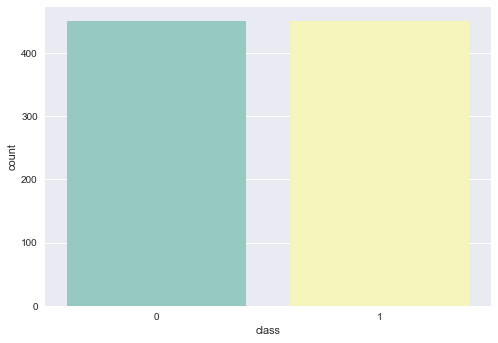

In [29]:
df = pd.read_csv('preprocessed_speech_features.csv', usecols = ['minintensity', 'mean_mfcc_2nd_coef', 'std_delta_delta_log_energy',
       'std_6th_delta_delta', 'std_8th_delta_delta',
       'std_11th_delta_delta', 'tqwt_energy_dec_25', 'tqwt_energy_dec_27',
       'tqwt_entropy_log_dec_27', 'tqwt_entropy_log_dec_33',
       'tqwt_entropy_log_dec_35', 'tqwt_tkeo_mean_dec_12',
       'tqwt_tkeo_std_dec_19', 'tqwt_stdvalue_dec_12',
       'tqwt_minvalue_dec_17', 'class'])

X = df.drop('class', axis = 1) 
y = df['class']

# train_test_split is used to split the dataset into test set and train set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 0)

X_train, y_train = ovsample(X_train, y_train)
sns.countplot(y_train, palette='Set3')

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [30]:
models = [LGBMClassifier(random_state = 42)]
model_names=['LGBMClassifier']
model_comparison(models, model_names)

,Algorithm,ROC_AUC,PR_AUC,Precision,Recall,F1_Train,F1_Test,Accuracy
0,LGBMClassifier,0.872807,0.960627,0.929825,0.938053,1.0,0.933921,0.901316


---------------------------------------------------------------


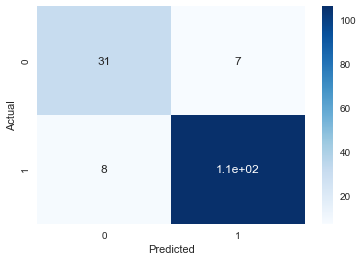

TP: 106, FP: 7, TN: 31, FN: 8
---------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.795     0.816     0.805        38
           1      0.938     0.930     0.934       114

    accuracy                          0.901       152
   macro avg      0.866     0.873     0.870       152
weighted avg      0.902     0.901     0.902       152

---------------------------------------------------------------
Recall Score: 0.9298
.
Macro Average of Recall Score: 0.8728
Weighted Average of Recall Score: 0.9013
---------------------------------------------------------------


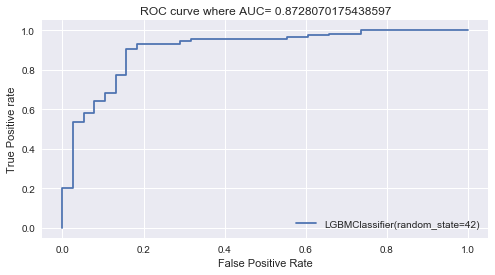

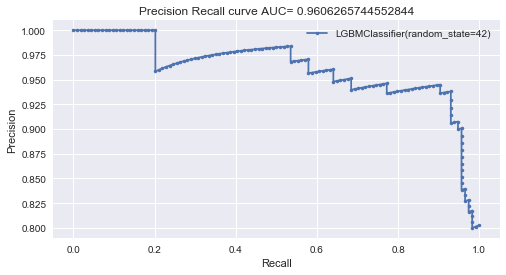

In [31]:
models = [LGBMClassifier(random_state = 42)]
roc_pr_cm(models)

## (c) Feature Selection: RandomForest Boruta

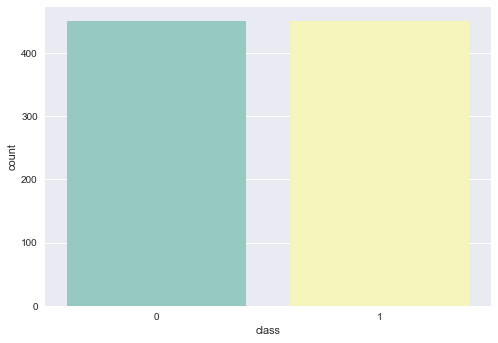

In [32]:
df = pd.read_csv('preprocessed_speech_features.csv')
df = df. drop('Unnamed: 0', axis=1)
df.columns = df.columns.str.lower()

X = df.drop('class', axis = 1) 
y = df['class']

# train_test_split is used to split the dataset into test set and train set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 0)

X_train, y_train = ovsample(X_train, y_train)
sns.countplot(y_train, palette='Set3')

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [33]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5, random_state=42)
rf.fit(X_train, y_train)

from boruta import BorutaPy
boruta_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)

# find all relevant features
boruta_selector.fit(np.array(X_train), np.array(y_train))

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	753
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	753
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	753
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	753
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	753
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	753
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	753
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	467
Tentative: 	286
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	467
Tentative: 	286
Rejected: 	0
Iteration: 	10 / 100
Confirmed: 	467
Tentative: 	286
Rejected: 	0
Iteration: 	11 / 100
Confirmed: 	467
Tentative: 	286
Rejected: 	0
Iteration: 	12 / 100
Confirmed: 	528
Tentative: 	225
Rejected: 	0
Iteration: 	13 / 100
Confirmed: 	528
Tentative: 	223
Rejected: 	2
Iteration: 	14 / 100
Confirmed: 	528
Tentative: 	223
Rejected: 	2
Iteration: 	15 / 100
Confirmed: 	528
Tentative: 	223
Rejected: 	2
Iteration: 	16 / 100
Confirmed: 	

BorutaPy(estimator=RandomForestClassifier(class_weight='balanced', max_depth=5,
                                          n_estimators=745, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x1D0FE31ED08),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x1D0FE31ED08, verbose=2)

In [34]:
# check selected features
print("Selected Features: ", boruta_selector.support_)

print ('----------------------------------------------------------------------------')
 
# check ranking of features
print("Ranking: ", boruta_selector.ranking_)

print ('----------------------------------------------------------------------------')

print("No. of significant features: ", boruta_selector.n_features_)

Selected Features:  [False False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False False False  True False
  True  True  True  True  True  True False False  True  True  True  True
  True  True  True  True False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
  True False False False  True False False False False False  True  True
 False False False False  True False False  True False  True False False
 False  True False  True False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False  True  True  True  True
  True False False False False False False False False False  True False
 False False False False  True 

In [35]:
green_area = X.columns[boruta_selector.support_].to_list()
blue_area = X.columns[boruta_selector.support_weak_].to_list()

print ('features in the green area:', green_area)

print ('============================================================================================================================================================================================================')

print ('features in the blue area:', blue_area)

features in the green area: ['dfa', 'rpde', 'numpulses', 'numperiodspulses', 'meanperiodpulses', 'stddevperiodpulses', 'locpctjitter', 'locabsjitter', 'rapjitter', 'ppq5jitter', 'ddpjitter', 'locshimmer', 'locdbshimmer', 'apq3shimmer', 'apq5shimmer', 'apq11shimmer', 'ddashimmer', 'meanautocorrharmonicity', 'meannoisetoharmharmonicity', 'meanharmtonoiseharmonicity', 'minintensity', 'maxintensity', 'meanintensity', 'f1', 'f2', 'f3', 'f4', 'b1', 'b2', 'gq_std_cycle_open', 'gne_mean', 'gne_std', 'gne_snr_tkeo', 'gne_snr_seo', 'gne_nsr_tkeo', 'gne_nsr_seo', 'vfer_entropy', 'vfer_snr_tkeo', 'vfer_snr_seo', 'vfer_nsr_tkeo', 'vfer_nsr_seo', 'imf_snr_seo', 'imf_snr_tkeo', 'imf_snr_entropy', 'imf_nsr_tkeo', 'imf_nsr_entropy', 'mean_log_energy', 'mean_mfcc_0th_coef', 'mean_mfcc_1st_coef', 'mean_mfcc_2nd_coef', 'mean_mfcc_3rd_coef', 'mean_mfcc_4th_coef', 'mean_mfcc_5th_coef', 'mean_mfcc_6th_coef', 'mean_mfcc_7th_coef', 'mean_mfcc_8th_coef', 'mean_mfcc_9th_coef', 'mean_mfcc_10th_coef', 'mean_mfcc_1

In [36]:
# Let's visualise it better in the form of a table
selected_boruta_features = pd.DataFrame({'Feature':list(X.columns),
                                      'Ranking':boruta_selector.ranking_})
selected_boruta_features.sort_values(by='Ranking')
selected_boruta_features = selected_boruta_features[selected_boruta_features['Ranking'] < 16]
top15 = selected_boruta_features.nsmallest(15,'Ranking')
top15 

,Feature,Ranking
2,dfa,1
3,rpde,1
4,numpulses,1
5,numperiodspulses,1
6,meanperiodpulses,1
7,stddevperiodpulses,1
8,locpctjitter,1
9,locabsjitter,1
10,rapjitter,1
11,ppq5jitter,1


In [37]:
top15.Feature.values

array(['dfa', 'rpde', 'numpulses', 'numperiodspulses', 'meanperiodpulses',
       'stddevperiodpulses', 'locpctjitter', 'locabsjitter', 'rapjitter',
       'ppq5jitter', 'ddpjitter', 'locshimmer', 'locdbshimmer',
       'apq3shimmer', 'apq5shimmer'], dtype=object)

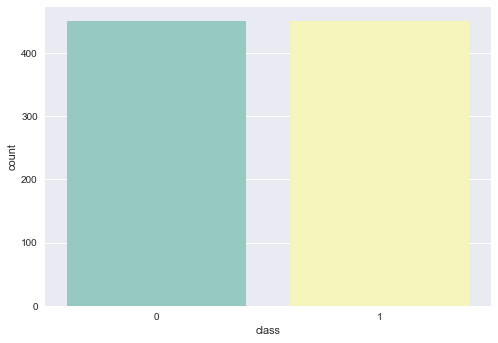

In [38]:
df = pd.read_csv('preprocessed_speech_features.csv', usecols = ['dfa', 'rpde', 'numpulses', 'numperiodspulses', 'meanperiodpulses',
       'stddevperiodpulses', 'locpctjitter', 'locabsjitter', 'rapjitter',
       'ppq5jitter', 'ddpjitter', 'locshimmer', 'locdbshimmer',
       'apq3shimmer', 'apq5shimmer', 'class'])

X = df.drop('class', axis = 1) 
y = df['class']

# train_test_split is used to split the dataset into test set and train set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 0)

X_train, y_train = ovsample(X_train, y_train)
sns.countplot(y_train, palette='Set3')

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [39]:
models = [LGBMClassifier(random_state = 42)]
model_names=['LGBMClassifier']
model_comparison(models, model_names)

,Algorithm,ROC_AUC,PR_AUC,Precision,Recall,F1_Train,F1_Test,Accuracy
0,LGBMClassifier,0.653509,0.941393,0.885965,0.821138,1.0,0.852321,0.769737


---------------------------------------------------------------


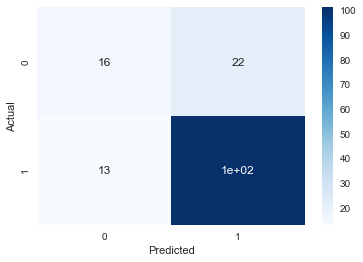

TP: 101, FP: 22, TN: 16, FN: 13
---------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.552     0.421     0.478        38
           1      0.821     0.886     0.852       114

    accuracy                          0.770       152
   macro avg      0.686     0.654     0.665       152
weighted avg      0.754     0.770     0.759       152

---------------------------------------------------------------
Recall Score: 0.886
.
Macro Average of Recall Score: 0.6535
Weighted Average of Recall Score: 0.7697
---------------------------------------------------------------


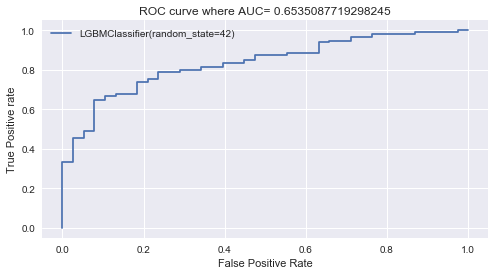

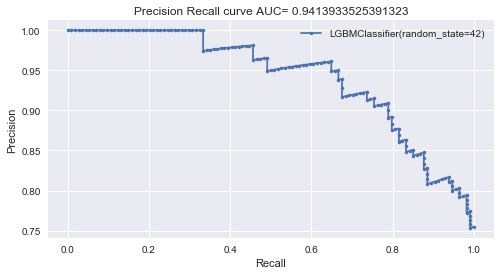

In [40]:
models = [LGBMClassifier(random_state = 42)]
roc_pr_cm(models)

## (d) Permutation Feature Importance

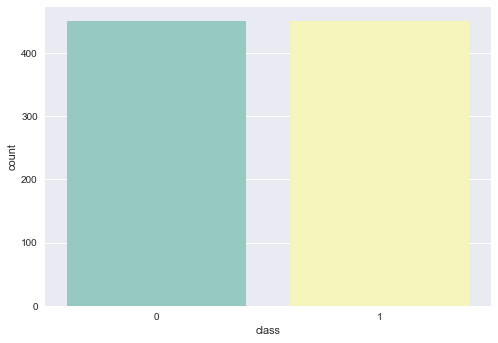

In [47]:
df = pd.read_csv('preprocessed_speech_features.csv')
df = df. drop('Unnamed: 0', axis=1)
df.columns = df.columns.str.lower()

X = df.drop('class', axis = 1) 
y = df['class']

# train_test_split is used to split the dataset into test set and train set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 0)

X_train, y_train = ovsample(X_train, y_train)
sns.countplot(y_train, palette='Set3')

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00000
Fe

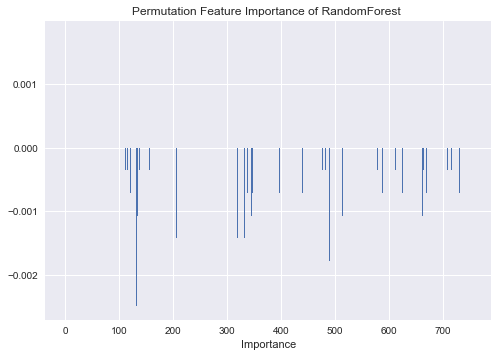

In [48]:
from sklearn.inspection import permutation_importance

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
# perform permutation importance
results = permutation_importance(model, X, y, scoring='recall')
# get importance
importance = results.importances_mean

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

    # plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.xlabel('Features')
plt.xlabel('Importance')
plt.title("Permutation Feature Importance of RandomForest ")
plt.show()

In [49]:
import warnings
warnings.filterwarnings('ignore')

idx_features = (-importance).argsort()[:15]
name_features = np.array(X.columns.to_list())[idx_features]
print('Selected features: {}'.format(name_features))

Selected features: ['tqwt_maxvalue_dec_21' 'gender' 'tqwt_tkeo_std_dec_22'
 'tqwt_tkeo_std_dec_23' 'tqwt_tkeo_std_dec_24' 'tqwt_tkeo_std_dec_25'
 'tqwt_tkeo_std_dec_27' 'tqwt_tkeo_std_dec_28' 'tqwt_tkeo_std_dec_29'
 'tqwt_tkeo_std_dec_30' 'tqwt_tkeo_std_dec_31' 'tqwt_tkeo_std_dec_33'
 'tqwt_tkeo_std_dec_34' 'tqwt_tkeo_std_dec_35' 'tqwt_tkeo_std_dec_36']


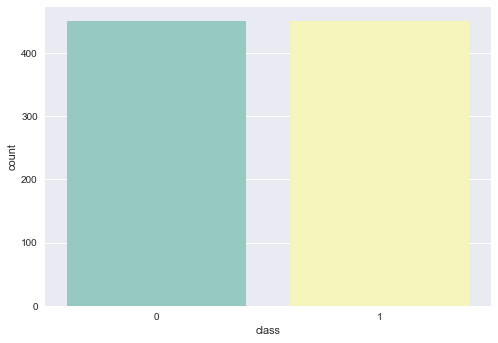

In [50]:
df = pd.read_csv('preprocessed_speech_features.csv', usecols = ['tqwt_maxvalue_dec_21', 'gender', 'tqwt_tkeo_std_dec_22',
 'tqwt_tkeo_std_dec_23', 'tqwt_tkeo_std_dec_24', 'tqwt_tkeo_std_dec_25',
 'tqwt_tkeo_std_dec_27', 'tqwt_tkeo_std_dec_28', 'tqwt_tkeo_std_dec_29',
 'tqwt_tkeo_std_dec_30', 'tqwt_tkeo_std_dec_31', 'tqwt_tkeo_std_dec_33',
 'tqwt_tkeo_std_dec_34', 'tqwt_tkeo_std_dec_35', 'tqwt_tkeo_std_dec_36','class'])

X = df.drop('class', axis = 1) 
y = df['class']

# train_test_split is used to split the dataset into test set and train set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 0)

X_train, y_train = ovsample(X_train, y_train)
sns.countplot(y_train, palette='Set3')

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [51]:
models = [LGBMClassifier(random_state = 42)]
model_names=['LGBMClassifier']
model_comparison(models, model_names)

,Algorithm,ROC_AUC,PR_AUC,Precision,Recall,F1_Train,F1_Test,Accuracy
0,LGBMClassifier,0.688596,0.933051,0.929825,0.834646,1.0,0.879668,0.809211


---------------------------------------------------------------


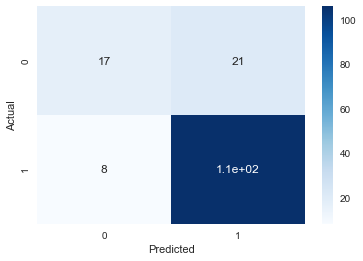

TP: 106, FP: 21, TN: 17, FN: 8
---------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.680     0.447     0.540        38
           1      0.835     0.930     0.880       114

    accuracy                          0.809       152
   macro avg      0.757     0.689     0.710       152
weighted avg      0.796     0.809     0.795       152

---------------------------------------------------------------
Recall Score: 0.9298
.
Macro Average of Recall Score: 0.6886
Weighted Average of Recall Score: 0.8092
---------------------------------------------------------------


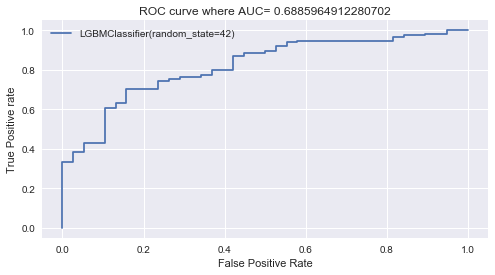

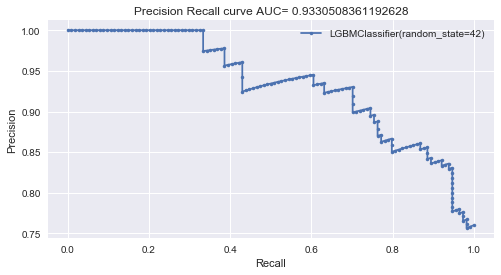

In [52]:
models = [LGBMClassifier(random_state = 42)]
roc_pr_cm(models)

## (e) Feature Importance using RandomForestClassifier

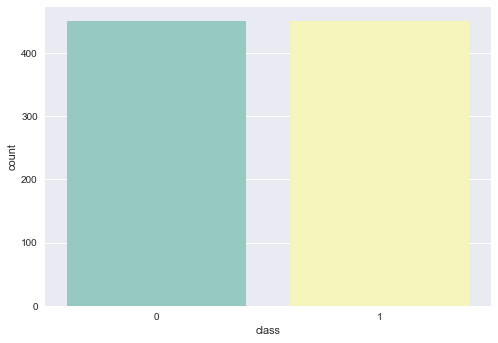

In [53]:
df = pd.read_csv('preprocessed_speech_features.csv')
df = df. drop('Unnamed: 0', axis=1)
df.columns = df.columns.str.lower()

X = df.drop('class', axis = 1) 
y = df['class']

# train_test_split is used to split the dataset into test set and train set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 0)

X_train, y_train = ovsample(X_train, y_train)
sns.countplot(y_train, palette='Set3')

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

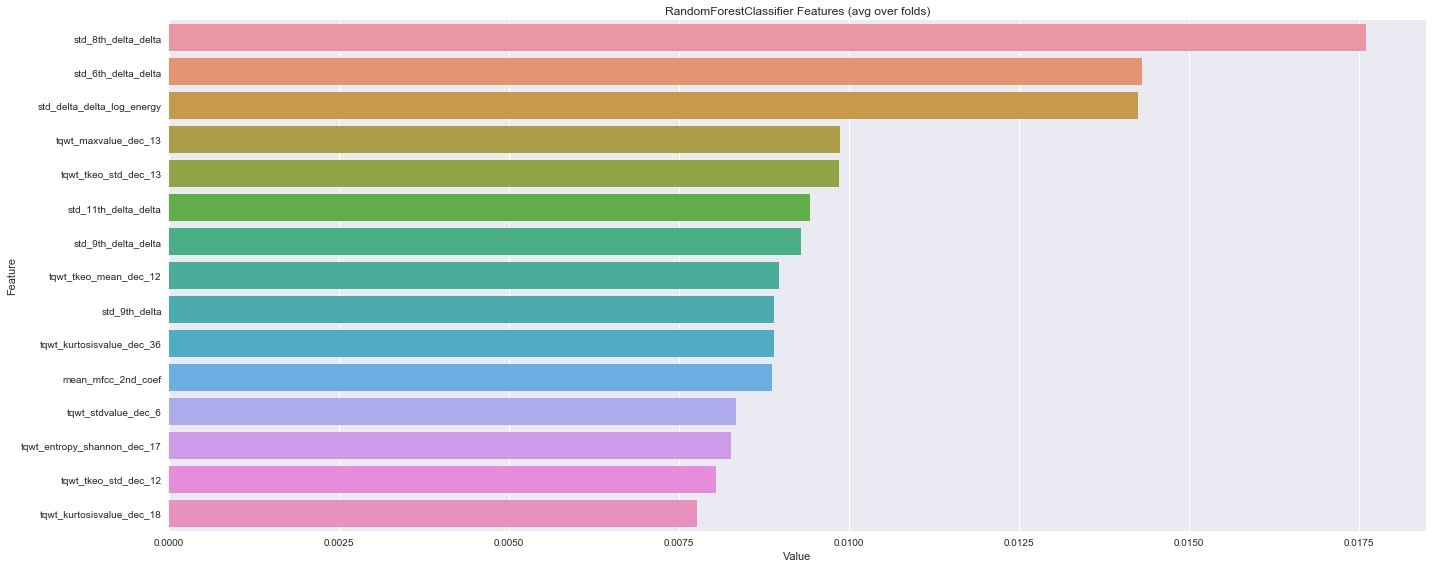

In [54]:
model = RandomForestClassifier(random_state=42)
# fit the model
model.fit(X_train, y_train)
# get importance
importance = model.feature_importances_

feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, X.columns), reverse=True), columns=['Value','Feature'])
feature_imp

top15 = feature_imp.nlargest(15,'Value')

plt.figure(figsize=(20, 8))
sns.barplot(x="Value", y="Feature", data=top15.sort_values(by="Value", ascending=False))
plt.title('RandomForestClassifier Features (avg over folds)')
plt.tight_layout()
plt.show()

In [55]:
rf_features = top15.Feature.to_list()
rf_features

['std_8th_delta_delta',
 'std_6th_delta_delta',
 'std_delta_delta_log_energy',
 'tqwt_maxvalue_dec_13',
 'tqwt_tkeo_std_dec_13',
 'std_11th_delta_delta',
 'std_9th_delta_delta',
 'tqwt_tkeo_mean_dec_12',
 'std_9th_delta',
 'tqwt_kurtosisvalue_dec_36',
 'mean_mfcc_2nd_coef',
 'tqwt_stdvalue_dec_6',
 'tqwt_entropy_shannon_dec_17',
 'tqwt_tkeo_std_dec_12',
 'tqwt_kurtosisvalue_dec_18']

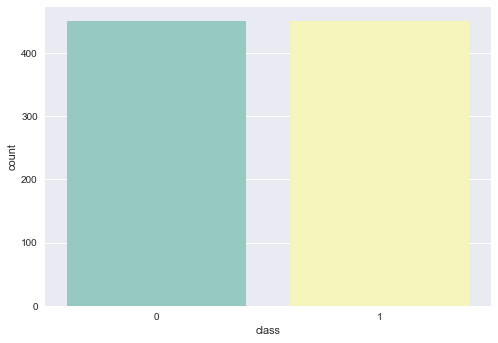

In [56]:
df = pd.read_csv('preprocessed_speech_features.csv', usecols  =['std_8th_delta_delta',
 'std_6th_delta_delta',
 'std_delta_delta_log_energy',
 'tqwt_maxvalue_dec_13',
 'tqwt_tkeo_std_dec_13',
 'std_11th_delta_delta',
 'std_9th_delta_delta',
 'tqwt_tkeo_mean_dec_12',
 'std_9th_delta',
 'tqwt_kurtosisvalue_dec_36',
 'mean_mfcc_2nd_coef',
 'tqwt_stdvalue_dec_6',
 'tqwt_entropy_shannon_dec_17',
 'tqwt_tkeo_std_dec_12',
 'tqwt_kurtosisvalue_dec_18', 'class'])


X = df.drop('class', axis = 1) 
y = df['class']

# train_test_split is used to split the dataset into test set and train set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 0)

X_train, y_train = ovsample(X_train, y_train)
sns.countplot(y_train, palette='Set3')

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [57]:
models = [LGBMClassifier(random_state = 42)]
model_names=['LGBMClassifier']
model_comparison(models, model_names)

,Algorithm,ROC_AUC,PR_AUC,Precision,Recall,F1_Train,F1_Test,Accuracy
0,LGBMClassifier,0.776316,0.955799,0.894737,0.886957,1.0,0.89083,0.835526


---------------------------------------------------------------


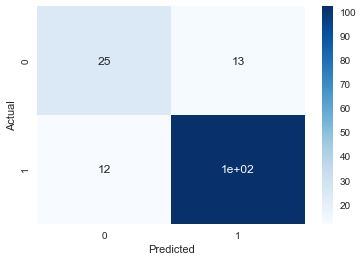

TP: 102, FP: 13, TN: 25, FN: 12
---------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.676     0.658     0.667        38
           1      0.887     0.895     0.891       114

    accuracy                          0.836       152
   macro avg      0.781     0.776     0.779       152
weighted avg      0.834     0.836     0.835       152

---------------------------------------------------------------
Recall Score: 0.8947
.
Macro Average of Recall Score: 0.7763
Weighted Average of Recall Score: 0.8355
---------------------------------------------------------------


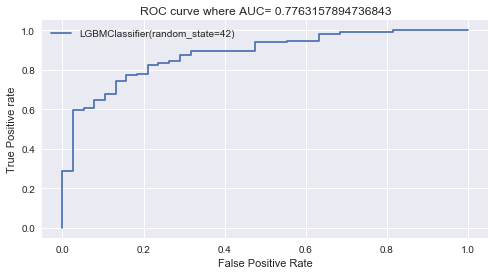

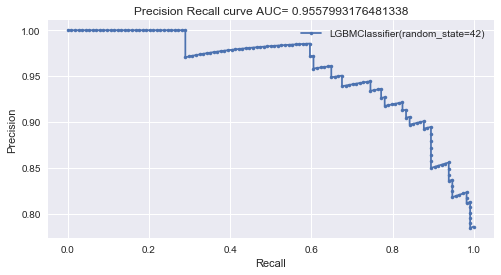

In [58]:
models = [LGBMClassifier(random_state = 42)]
roc_pr_cm(models)

## (f) Feature Importance using XGBoostClassifier

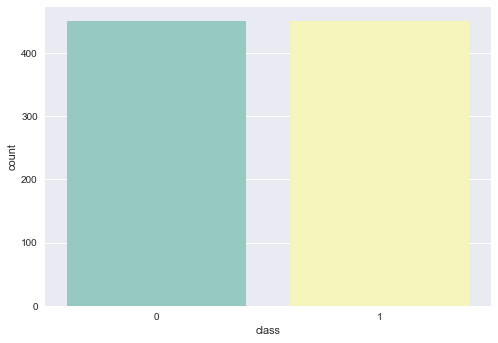

In [59]:
df = pd.read_csv('preprocessed_speech_features.csv')
df = df. drop('Unnamed: 0', axis=1)
df.columns = df.columns.str.lower()

X = df.drop('class', axis = 1) 
y = df['class']

# train_test_split is used to split the dataset into test set and train set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 0)

X_train, y_train = ovsample(X_train, y_train)
sns.countplot(y_train, palette='Set3')

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

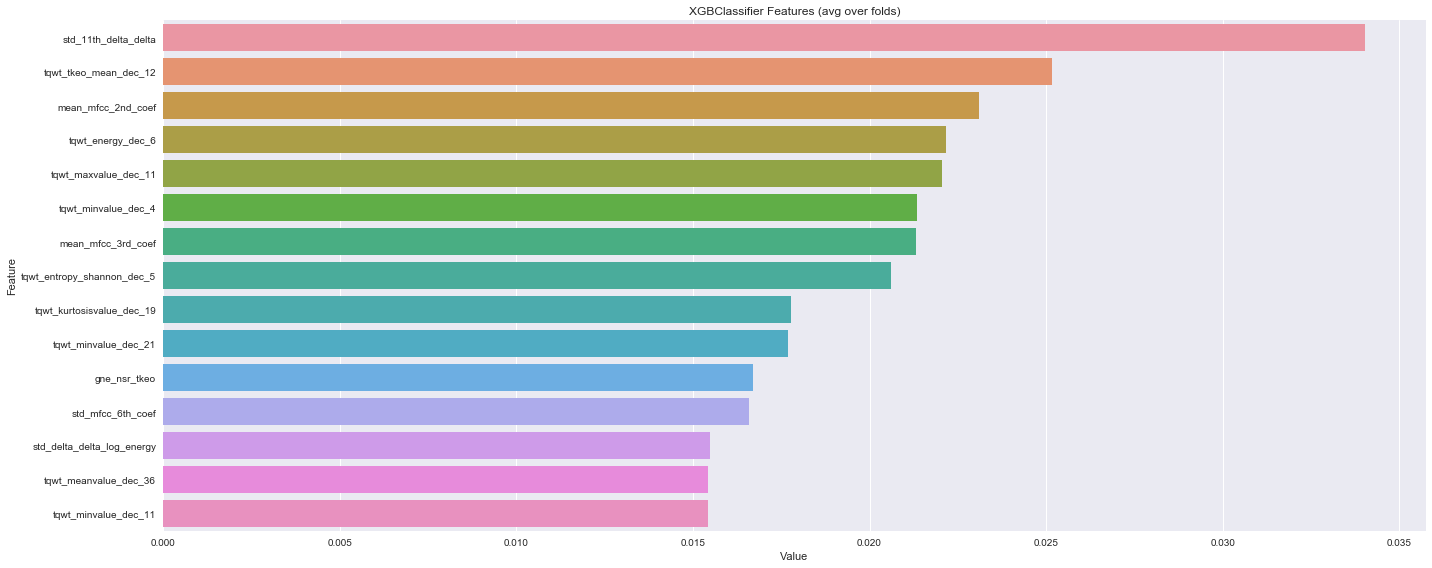

In [60]:
model = XGBClassifier(random_state=42)
# fit the model
model.fit(X_train, y_train)
# get importance
importance = model.feature_importances_

feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, X.columns), reverse=True), columns=['Value','Feature'])
feature_imp

top15 = feature_imp.nlargest(15,'Value')

plt.figure(figsize=(20, 8))
sns.barplot(x="Value", y="Feature", data=top15.sort_values(by="Value", ascending=False))
plt.title('XGBClassifier Features (avg over folds)')
plt.tight_layout()
plt.show()

In [61]:
xgb_features = top15.Feature.to_list()
xgb_features

['std_11th_delta_delta',
 'tqwt_tkeo_mean_dec_12',
 'mean_mfcc_2nd_coef',
 'tqwt_energy_dec_6',
 'tqwt_maxvalue_dec_11',
 'tqwt_minvalue_dec_4',
 'mean_mfcc_3rd_coef',
 'tqwt_entropy_shannon_dec_5',
 'tqwt_kurtosisvalue_dec_19',
 'tqwt_minvalue_dec_21',
 'gne_nsr_tkeo',
 'std_mfcc_6th_coef',
 'std_delta_delta_log_energy',
 'tqwt_meanvalue_dec_36',
 'tqwt_minvalue_dec_11']

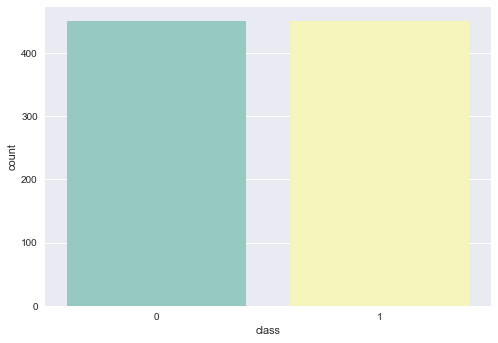

In [62]:
df = pd.read_csv('preprocessed_speech_features.csv', usecols = ['std_11th_delta_delta',
 'tqwt_tkeo_mean_dec_12',
 'mean_mfcc_2nd_coef',
 'tqwt_energy_dec_6',
 'tqwt_maxvalue_dec_11',
 'tqwt_minvalue_dec_4',
 'mean_mfcc_3rd_coef',
 'tqwt_entropy_shannon_dec_5',
 'tqwt_kurtosisvalue_dec_19',
 'tqwt_minvalue_dec_21',
 'gne_nsr_tkeo',
 'std_mfcc_6th_coef',
 'std_delta_delta_log_energy',
 'tqwt_meanvalue_dec_36',
 'tqwt_minvalue_dec_11', 'class'])


X = df.drop('class', axis = 1) 
y = df['class']

# train_test_split is used to split the dataset into test set and train set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 0)

X_train, y_train = ovsample(X_train, y_train)
sns.countplot(y_train, palette='Set3')

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [63]:
models = [LGBMClassifier(random_state = 42)]
model_names=['LGBMClassifier']
model_comparison(models, model_names)

,Algorithm,ROC_AUC,PR_AUC,Precision,Recall,F1_Train,F1_Test,Accuracy
0,LGBMClassifier,0.758772,0.934558,0.885965,0.878261,1.0,0.882096,0.822368


---------------------------------------------------------------


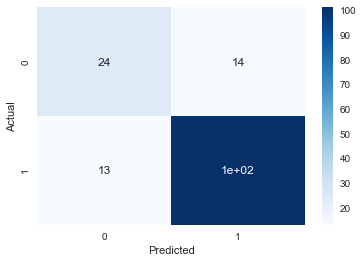

TP: 101, FP: 14, TN: 24, FN: 13
---------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.649     0.632     0.640        38
           1      0.878     0.886     0.882       114

    accuracy                          0.822       152
   macro avg      0.763     0.759     0.761       152
weighted avg      0.821     0.822     0.822       152

---------------------------------------------------------------
Recall Score: 0.886
.
Macro Average of Recall Score: 0.7588
Weighted Average of Recall Score: 0.8224
---------------------------------------------------------------


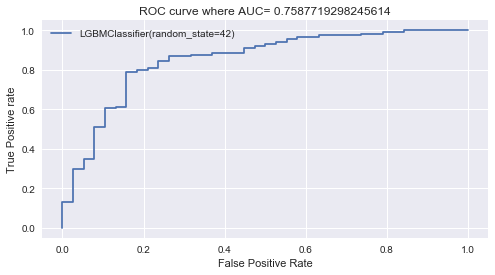

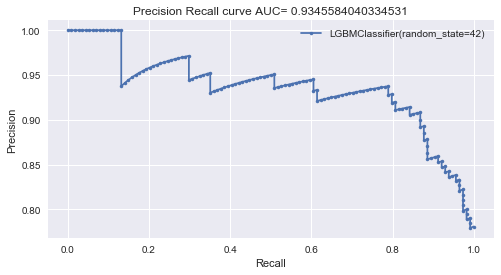

In [64]:
models = [LGBMClassifier(random_state = 42)]
roc_pr_cm(models)

## Conclusion

### Selected Features: (a) Feature selection using SelectFromModel and LassoCV

- Recall Score: 0.9561
- Macro Average of Recall Score: 0.7939
- Weighted Average of Recall Score: 0.875

['tqwt_entropy_log_dec_33', 'tqwt_minvalue_dec_25',
 'tqwt_entropy_shannon_dec_25', 'tqwt_meanvalue_dec_36',
 'tqwt_kurtosisvalue_dec_33', 'tqwt_kurtosisvalue_dec_31',
 'tqwt_maxvalue_dec_17', 'std_9th_delta', 'tqwt_maxvalue_dec_13',
 'tqwt_entropy_log_dec_28', 'tqwt_tkeo_std_dec_19', 'tqwt_meanvalue_dec_22',
 'imf_snr_seo', 'tqwt_meanvalue_dec_5', 'tqwt_kurtosisvalue_dec_27', 'class']